# Analysis and Inference of experiment `33PD`
This notebook plots the data from the experiment `33PD` and the agent-based model. The parameters of this agent-based models were inferred using particle swarm algorithm and the `33PD` data. 

### Import all the required libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load the experimental data as a dataframe

In [4]:
df = pd.read_csv("../data/experiments/data_exp33PD.csv", header=0).drop(0).drop("Unnamed: 0", axis=1)
df[df.columns[::2]] = df[df.columns[::2]].astype(int)
df.columns

Index(['02_DMSO alltime', '02_DMSO alltime.1', '03_10um alltime',
       '03_10um alltime.1', '04_500um alltime', '04_500um alltime.1',
       '05_Control 30 min removed', '05_Control 30 min removed.1',
       '06_DMSO30 min removed', '06_DMSO30 min removed.1',
       '07_10um 30 min removed', '07_10um 30 min removed.1',
       '08_500um 30 min removal', '08_500um 30 min removal.1',
       '09_Control 2h removal', '09_Control 2h removal.1',
       '10_DMSO 2h removal', '10_DMSO 2h removal.1', '11_10um 2h removal',
       '11_10um 2h removal.1', '12_500um 2h removal', '12_500um 2h removal.1',
       '01_Control', '01_Control.1'],
      dtype='object')

In [5]:
DMSO = [
    "02_DMSO alltime",
    "06_DMSO30 min removed",
    "10_DMSO 2h removal"
]

TMZ10 = [
    "03_10um alltime",
    "07_10um 30 min removed",
    "11_10um 2h removal"
]

TMZ500 = [
    "04_500um alltime",
    "08_500um 30 min removal",
    "12_500um 2h removal"
]

df.loc[:, DMSO]

,02_DMSO alltime,06_DMSO30 min removed,10_DMSO 2h removal
1,290,123,168
2,337,136,168
3,356,125,169
4,329,130,182
5,347,138,202
...,...,...,...
137,981,517,585
138,975,525,565
139,990,512,588
140,999,507,586


## Plot the fold change over time
We want to compare the _DMSO_ control and the 500 uM _TMZ_ treamtments. To calculate the fold change in cell numbers we normalize the timeseries by dividing with the 11th observation.

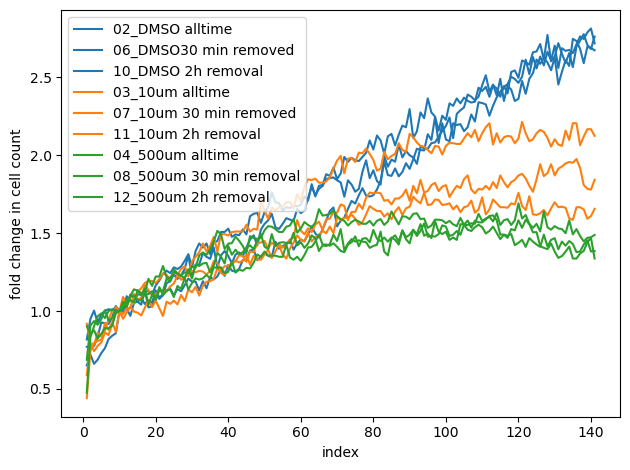

In [6]:
fig, ax = plt.subplots()
for treatment, color in zip([DMSO, TMZ10, TMZ500], ["C{}".format(i) for i in range(3)]):
    (df.loc[:, treatment] / df.loc[10, treatment]).plot(ax = ax, color = color)
plt.xlabel("index")
plt.ylabel("fold change in cell count")
plt.tight_layout()

### Plot the predicted fold change
Using the above data points we parametried an agent-based model. This model explicitly considers cell two abstract cell cycle stages; 1. where cells get methylated by TMZ, and 2. where methylated cells die. The cell populations cycles through these stages. One model step is equivalent of 30 min timestep, which is referred to as one unit of time. The model consists of following parameters:
- `l1`: lenght of the stage (in multiple of time units) where neither methylation nor death occurs
- `l2`: length of the stage (in multiple of time units) where methylation occurs
- `L`: length of the cell cycle (in multiple of time units), i.e. doubling time
- `p_drug10`: the probability of methylation in one unit of time for 10um Temozolomide
- `p_drug500`: the probability of methylation in one unit of time for 500um Temozolomide

In [7]:
# uncomment the next line to re-run optimization ~5min
#!julia --project=.. inference.jl

parameters = pd.read_csv("../data/inference/parameters.csv", header=None).iloc[:,0].to_list()
parameters
print("\n--- Best-fit parameter values ---")
for name, p in zip(["l1","l2","L","p_drug10","p_drug500"], parameters):
    if len(name) <= 2: print(name, " : ", int(p))
    else: print(name, " : ", r"{:.3f} h^-1 ".format(2*p))


--- Best-fit parameter values ---
l1  :  0
l2  :  30
L  :  82
p_drug10  :  0.093 h^-1 
p_drug500  :  1.828 h^-1 


In case of _DMSO_ we assume that the probability of methylation `p_drug = 0`. The trajectories corresponding to the best-fit parameters are plotted below.

Text(0, 0.5, 'fold change in cell count')

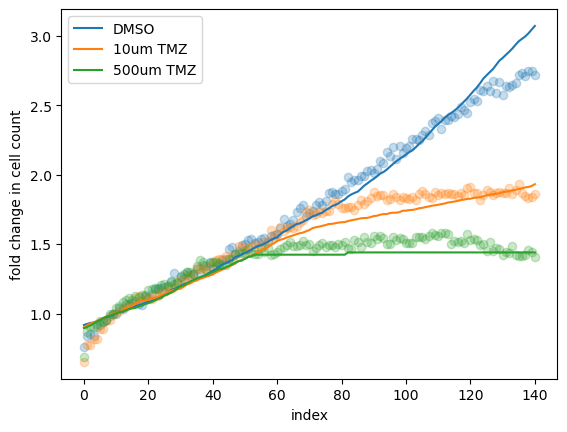

In [8]:
pdf = pd.read_csv("../data/inference/fitted_exp33PD.csv")
x = np.arange(0,141)
plt.figure()

DMSO_ts = df.loc[:, DMSO].mean(axis=1)
TMZ10_ts = df.loc[:, TMZ10].mean(axis=1)
TMZ500_ts = df.loc[:, TMZ500].mean(axis=1)
plt.scatter(x, DMSO_ts / DMSO_ts[10], alpha=0.25, color="C0")
plt.scatter(x, TMZ10_ts / TMZ10_ts[10], alpha=0.25, color="C1")
plt.scatter(x, TMZ500_ts / TMZ500_ts[10], alpha=0.25, color="C2")

plt.plot(pdf.index, (pdf.DMSO) / (pdf.DMSO)[10], label="DMSO", color="C0")
plt.plot(pdf.index, (pdf.TMZ10) / (pdf.TMZ10)[10], label="10um TMZ", color="C1")
plt.plot(pdf.index, (pdf.TMZ500) / (pdf.TMZ500)[10], label="500um TMZ", color="C2")
plt.legend()
plt.xlabel("index")
plt.ylabel("fold change in cell count")